interesting stuff:
--
1. common in x, rare in z: stop words.
2. rel class distribution is different than x_norm class distribution: find a few explainable examples & give example sentence
3. False Analysis - what charactarizes the rationales with strong falses?
4. words that are especially common in the rationales: z_norm / x_norm

interesting figures:
--
1. rationale length (percent) distribution
2. rel distribution (without tiny words)



In [27]:
import numpy as np
import pandas as pd
import os
import os.path as osp
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [2]:
# p = 'exp2_rationales.json'
p = r'rationales_newsroom_sp003_ch0.json'
# p = r'rationales_newsroom_sp0003_ch05.json'
df = pd.read_json(p, orient='records', lines=True)
df['y'] = df['y'].apply(lambda x: x[0])

In [199]:
def list2array(x):
    if isinstance(x, list):
        return np.array(x)
    return x

def get_z_ids(row):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    return x[z].tolist()

df = df.applymap(list2array)
df['z_ids'] = df.apply(get_z_ids, axis='columns')
df['pred_class'] = df['p_r'].apply(np.argmax)
df['short_rationale'] = df['rationale'].apply(lambda s: s.replace('__ ', '').replace('__', ''))

In [151]:
def softmax(logits):
    logits -= logits.max()
    scores = np.exp(logits)
    scores /= scores.sum()
    return scores

df['scores'] = df['p_r'].apply(softmax)

In [152]:
def get_score(row, col_name):
    return row['scores'][row[col_name]]

df['score_pred'] = df.apply(lambda row: get_score(row, 'pred_class'), axis='columns')
df['score_y'] = df.apply(lambda row: get_score(row, 'y'), axis='columns')

In [153]:
conf_mat = confusion_matrix(df['y'], df['pred_class'])
# pd.DataFrame(((conf_mat + conf_mat.T)/2).astype(int))
pd.DataFrame(conf_mat)

0    1     2    3    4
0  480   48   160   76   69
1  113  322   213   14   47
2  106   56  1229   17  122
3  114   16    83  462   24
4  148   63   328   45  509

In [154]:
d = pd.DataFrame(df['x'].apply(len))
d.columns = ['sentence lens']

with pd.option_context('display.max_rows', 6):
    display(d)

sentence lens
0               132
1               132
2               132
...             ...
4861            809
4862            809
4863            809

[4864 rows x 1 columns]

In [155]:
all_words = (' '.join(df['text'])).split(' ')
all_ids = np.hstack(df['x'])
vocab = pd.DataFrame()
vocab['word'] = all_words
vocab.index = all_ids
vocab.drop_duplicates(inplace=True)
vocab.sort_index(inplace=True)
vocab.index.name = 'word_id'

In [156]:
vocab[vocab['word'] == 'tasty']

word
word_id       
25109    tasty

# Rationales Sizes

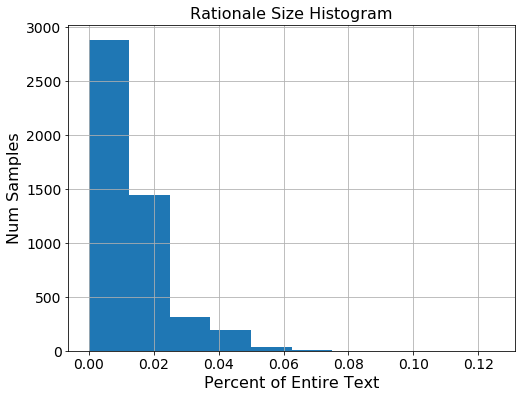

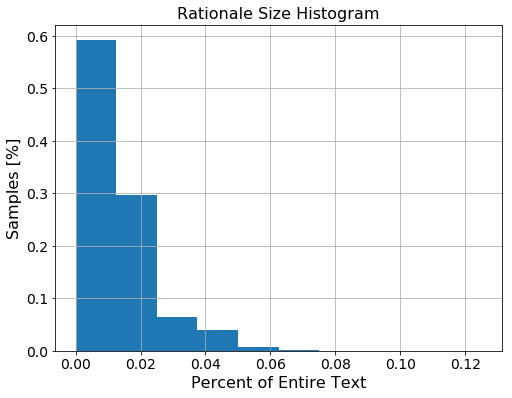

In [157]:
z_percent = df['z'].apply(np.mean)

z_percent.hist(figsize=(8,6))
plt.tick_params(labelsize=14)
plt.title('Rationale Size Histogram', fontsize=16)
plt.xlabel('Percent of Entire Text', fontsize=16)
plt.ylabel('Num Samples', fontsize=16)
plt.show()

fig = plt.figure(figsize=(8,6))
vals, edges = np.histogram(z_percent.values)
vals = vals / float(vals.sum())
plt.bar(edges[:-1], vals, width=edges[1]-edges[0], align='edge')
plt.grid()
plt.tick_params(labelsize=14)
plt.title('Rationale Size Histogram', fontsize=16)
plt.xlabel('Percent of Entire Text', fontsize=16)
plt.ylabel('Samples [%]', fontsize=16)
plt.show()
fig.savefig(osp.splitext(p)[0] + 'rationale_size_hist.png')

# rel class distribution

In [158]:
def get_value_counts(a):
    a = pd.Series(np.hstack(a))
    counts = a.value_counts()
    return counts

def get_relative_counts(df):
    g = df.groupby('y')
    x_counts = g['x'].apply(get_value_counts)
    z_counts = g['z_ids'].apply(get_value_counts)
    rel_counts = z_counts / x_counts
    rel_counts.fillna(0, inplace=True)
    return x_counts, z_counts, rel_counts

is_tp = df['pred_class'] == df['y']
df_tp = df[is_tp]
df_fp = df[~is_tp]

x_counts_tp, z_counts_tp, rel_counts_tp = get_relative_counts(df_tp)
x_counts_fp, z_counts_fp, rel_counts_fp = get_relative_counts(df_fp)
x_counts_all, z_counts_all, rel_counts_all = get_relative_counts(df)

In [205]:
x_counts, z_counts, rel_counts = x_counts_tp, z_counts_tp, rel_counts_tp
# x_counts, z_counts, rel_counts = x_counts_fp, z_counts_fp, rel_counts_fp

In [160]:
def to_by_class(rel):
    rel = pd.DataFrame(rel).unstack(level=0)
    rel.columns = rel.columns.droplevel()
    rel.columns.name = 'class'
    rel.index.name = 'word_id'
    rel.fillna(0, inplace=True)
    return rel

x_cls = to_by_class(x_counts)
z_cls = to_by_class(z_counts)
rel_cls = to_by_class(rel_counts)
stds = rel_cls.std(axis='columns')
x_cls_norm = x_cls / x_cls.sum(axis=0)
z_cls_norm = z_cls / z_cls.sum(axis=0)
norm_rel = (z_cls_norm / x_cls_norm).fillna(0)

In [161]:
thresh_all_x = 0
thresh_other_x = 5
thresh_curr_z = 100
min_std = -1 # 0.05
sort_by = 'curr_class_weight' # 'std' or 'curr_class_weight'
only_if_curr_is_argmax = False
i_cls = 2 # which class to check

atleast_all_x = x_cls.index[(x_cls > thresh_all_x).all(axis=1)]
atleast_curr_z = z_cls.index[z_cls[i_cls] > thresh_curr_z]
atleast_other_x = x_cls.index[(x_cls.drop(columns=[i_cls]) > thresh_other_x).any(axis=1)]

atleast_indices = atleast_all_x.intersection(atleast_curr_z).intersection(atleast_other_x)
atleast = (x_cls.iloc[:,0] * 0).astype(bool)
atleast.loc[atleast_indices] = True

if only_if_curr_is_argmax:
    curr_is_argmax = rel_cls.idxmax(axis=1) == i_cls
else:
    curr_is_argmax = atleast.copy()
    curr_is_argmax[:] = True

keep = atleast & (rel_cls[i_cls] != 0) & curr_is_argmax & (stds > min_std)

if sort_by == 'std':
    sort_inds = stds[keep].sort_values(ascending=False).index
elif sort_by == 'curr_class_weight':
    sort_inds = rel_cls[keep][i_cls].sort_values(ascending=False).index

words_df = vocab.loc[sort_inds]
words = words_df['word'].iloc[:50]
# words = ['amazing', 'worst', 'dull', 'awesome']
# words = ['christmas', 'hot', 'somewhat', 'typical']  # min_samples=10

for word in words:
    word_id = vocab[vocab['word'] == word].index[0]
    print(word_id)

    print(word)
    for i_cls in range(z_cls.shape[1]):
        if float(word_id) in z_cls.index:
            print(z_cls.loc[word_id, i_cls], '/', x_cls.loc[word_id, i_cls], '=', rel_cls.loc[word_id, i_cls])
    print('std =', stds.loc[word_id])
    print()

1328
—
101.0 / 101.0 = 1.0
314.0 / 314.0 = 1.0
2987.0 / 2987.0 = 1.0
6.0 / 6.0 = 1.0
925.0 / 925.0 = 1.0
std = 0.0

1759
article
12.0 / 12.0 = 1.0
2.0 / 2.0 = 1.0
490.0 / 521.0 = 0.9404990403071017
33.0 / 35.0 = 0.9428571428571428
5.0 / 6.0 = 0.8333333333333334
std = 0.06806335668354782

735
published
33.0 / 38.0 = 0.868421052631579
7.0 / 9.0 = 0.7777777777777778
132.0 / 169.0 = 0.7810650887573964
38.0 / 47.0 = 0.8085106382978723
148.0 / 151.0 = 0.9801324503311258
std = 0.08475075499802671

836
wrote
23.0 / 35.0 = 0.6571428571428571
17.0 / 26.0 = 0.6538461538461539
131.0 / 214.0 = 0.6121495327102804
49.0 / 77.0 = 0.6363636363636364
39.0 / 54.0 = 0.7222222222222222
std = 0.04092426980866875

539
book
4.0 / 13.0 = 0.3076923076923077
1.0 / 14.0 = 0.07142857142857142
104.0 / 302.0 = 0.3443708609271523
23.0 / 57.0 = 0.40350877192982454
12.0 / 26.0 = 0.46153846153846156
std = 0.1495942456384957

400001
<padding>
217.0 / 16285.0 = 0.013325145839729814
77.0 / 10440.0 = 0.007375478927203065
449

# False Analysis

In [263]:
# y = 1
# pred_class = 0
y = 0
pred_class = 4

df_fp = df[(df['y'] == y) & (df['pred_class'] == pred_class)]
sort_inds = (df_fp['score_pred'] / df_fp['score_y']).sort_values(ascending=False).index
df_fp = df_fp.loc[sort_inds]

df_tp = df[(df['y'] == y) & (df['pred_class'] == y)].sort_values(by='score_y', ascending=False)

df_tp[['short_rationale', 'score_pred', 'score_y']].head(100)
df_fp[['short_rationale', 'score_pred', 'score_y']].head(100)

# df_fp['short_rationale'].apply(lambda s: '20' in s).mean()
# df_tp['short_rationale'].apply(lambda s: '20' in s).mean()

# df_fp['short_rationale'].apply(lambda s: 'newspaper' in s)
# df_fp['short_rationale'].apply(lambda s: '20' in s)

# df_fp['short_rationale'].apply(lambda s: ('2015' in s) or ('2013' in s)).mean()
# df_tp['short_rationale'].apply(lambda s: ('2015' in s) or ('2013' in s)).mean()


short_rationale  score_pred   score_y
2424  <padding> <unk> speaks columnist poetry — — — ...    0.402736  0.148163
3466                  wrote thoughts <unk> 1989 writes     0.404581  0.148842
3342                                        ( anti-war     0.404581  0.148843
4488            <padding> … — assigned — — experiences     0.396901  0.146019
1709  history op-ed middle-class 20th century newspa...    0.377215  0.138779
4615                    subjects concerning — — person     0.324356  0.119334
3105  <unk> <unk> <unk> 19th century columnist write...    0.386299  0.142131
1438                                   — — — columnist     0.403347  0.148405
3220  newscasts second-place prophecies newscasts ne...    0.390153  0.143578
747           — — so-called earliest — — 2016 material     0.402718  0.148266
2746   aunt mother — person article contributor editor     0.392789  0.144647
3160                          writers film story story     0.341712  0.125848
2558  photo loosely description — — dedicated transl...    0.331342  0.122036
4020  <padding> <unk> presents award thoughts — 2014 ”     0.402929  0.148433
277   <padding> <padding> <padding> library library ...    0.341841  0.126260
4747  2011 experiences blogger editor editor writer ...    0.399230  0.147503
2772  columnist columns columns – essay writes class...    0.360082  0.133185
1512  open-ended so-called written events 2013 conse...    0.373830  0.138566
1051  <padding> — 2012 — — character 1978 died write...    0.304512  0.112964
4699             <padding> hurling existed 10:20 <unk>     0.326426  0.121291
516   university lived newspaper — — hockey — — — — ...    0.318730  0.118977
3359                                    matters hockey     0.403035  0.150562
2410   <padding> <unk> celebrates exhibition – — — — —     0.324040  0.121920
2913           columnist personality businessman books     0.401223  0.152538
2232            2013 integrates apps intuitive display     0.398392  0.152865
2974      liberal jurist between covering became <unk>     0.329522  0.127070
3402                           soccer violate covering     0.400053  0.157475
1951  entitled non-governmental + entitled defines e...    0.328979  0.130040
3954                                       description     0.387534  0.153685
2123                   prohibition individual bisexual     0.319635  0.127456
...                                                 ...         ...       ...
4444        fossils contents — covering — journal 2012     0.345338  0.194198
1565                              — 2016 — 2016 — 2016     0.370474  0.220652
1675                                        historians     0.288143  0.174752
1258                  — correspondent blog contributed     0.366685  0.228602
4313                                      heroic wrote     0.283377  0.185637
2744  <padding> <unk> – <unk> — — 2014 published — b...    0.272497  0.186068
4635  event feminist pamphlets wrote page — — wrote ...    0.303312  0.214653
3442                                 concerning famous     0.257144  0.196894
558                                             league     0.299004  0.240125
3495                                           pursuit     0.297215  0.258737
4025                               church wrote e-mail     0.252346  0.223843
3265  conflict 2011 2011 writes 2011 wrote 2012 page...    0.327931  0.294082
3532                                   covering mother     0.332688  0.298578
477                      anniversary mentioned debates     0.274938  0.247396
3037                             2010 reading assigned     0.331731  0.301508
1624                               occurs death lyrics     0.258133  0.235167
965                         – co-founder online covers     0.328269  0.300879
2092        re-election re-election contributor author     0.292041  0.276056
4239                                       stamp reads     0.204050  0.197955
1742                    retired biographer contributed     0.3

# Variable Explanations

In [163]:
print('x_cls: how many text appearances for each word?')
with pd.option_context('display.max_rows',6):
    display(x_cls)

x_cls: how many text appearances for each word?


class          0        1         2        3        4
word_id                                              
0        12456.0   5924.0   54129.0  19694.0  13187.0
1            1.0      8.0     112.0     11.0      9.0
2           11.0     49.0      90.0      7.0     99.0
...          ...      ...       ...      ...      ...
399717       1.0      0.0       0.0      0.0      0.0
400000   63681.0  37162.0  269522.0  90558.0  90314.0
400001   16285.0  10440.0   52172.0  18635.0  16369.0

[37283 rows x 5 columns]

In [164]:
print('x_cls: how many rationale appearances for each word?')
with pd.option_context('display.max_rows',6):
    display(z_cls)

x_cls: how many rationale appearances for each word?


class         0      1      2      3      4
word_id                                    
0.0         0.0    1.0    2.0    0.0    0.0
3.0         0.0    0.0    5.0    2.0    0.0
5.0         2.0    1.0    9.0    3.0    1.0
...         ...    ...    ...    ...    ...
398229.0    0.0    0.0    0.0    0.0    1.0
400000.0  546.0  826.0  848.0  132.0  235.0
400001.0  217.0   77.0  449.0  146.0  108.0

[3269 rows x 5 columns]

In [165]:
print('rel_cls: num_in_rationale / num_in_text')
with pd.option_context('display.max_rows',6):
    display(rel_cls)

rel_cls: num_in_rationale / num_in_text


class            0         1         2         3         4
word_id                                                   
0.0       0.000000  0.000169  0.000037  0.000000  0.000000
1.0       0.000000  0.000000  0.000000  0.000000  0.000000
2.0       0.000000  0.000000  0.000000  0.000000  0.000000
...            ...       ...       ...       ...       ...
399717.0  0.000000  0.000000  0.000000  0.000000  0.000000
400000.0  0.008574  0.022227  0.003146  0.001458  0.002602
400001.0  0.013325  0.007375  0.008606  0.007835  0.006598

[37283 rows x 5 columns]

In [166]:
print('stds: std(rel_cls). how different beween classes?')
with pd.option_context('display.max_rows',6):
    display(stds)

stds: std(rel_cls). how different beween classes?


word_id
0.0         0.000073
1.0         0.000000
2.0         0.000000
              ...   
399717.0    0.000000
400000.0    0.008623
400001.0    0.002660
Length: 37283, dtype: float64

In [167]:
print('x_cls_norm: word occurence in entire text corpus\n3.3% of the words in class 0 are the word with id 0, which is "the".')
with pd.option_context('display.max_rows',6):
    display(x_cls_norm)

x_cls_norm: word occurence in entire text corpus
3.3% of the words in class 0 are the word with id 0, which is "the".


class           0         1         2         3         4
word_id                                                  
0        0.048546  0.043912  0.050935  0.050903  0.043095
1        0.000004  0.000059  0.000105  0.000028  0.000029
2        0.000043  0.000363  0.000085  0.000018  0.000324
...           ...       ...       ...       ...       ...
399717   0.000004  0.000000  0.000000  0.000000  0.000000
400000   0.248191  0.275464  0.253620  0.234066  0.295148
400001   0.063469  0.077387  0.049094  0.048166  0.053494

[37283 rows x 5 columns]

In [168]:
print('z_cls_norm: word occurence in entire rationale corpus\n0.004% of the words in class 0 are the word with id 0, which is "the".')
with pd.option_context('display.max_rows',6):
    display(z_cls_norm)

z_cls_norm: word occurence in entire rationale corpus
0.004% of the words in class 0 are the word with id 0, which is "the".


class            0         1         2         3         4
word_id                                                   
0.0       0.000000  0.000422  0.000148  0.000000  0.000000
3.0       0.000000  0.000000  0.000371  0.000390  0.000000
5.0       0.000863  0.000422  0.000668  0.000585  0.000227
...            ...       ...       ...       ...       ...
398229.0  0.000000  0.000000  0.000000  0.000000  0.000227
400000.0  0.235650  0.348818  0.062945  0.025726  0.053300
400001.0  0.093656  0.032517  0.033328  0.028454  0.024495

[3269 rows x 5 columns]

In [169]:
print('norm_rel: occurence_in_z / occurence in x.\nlarger than 1 --> words are more prominent in the rationales than they are in the text.')
with pd.option_context('display.max_rows',6):
    display(norm_rel)

norm_rel: occurence_in_z / occurence in x.
larger than 1 --> words are more prominent in the rationales than they are in the text.


class            0         1         2         3         4
word_id                                                   
0.0       0.000000  0.009617  0.002915  0.000000  0.000000
1.0       0.000000  0.000000  0.000000  0.000000  0.000000
2.0       0.000000  0.000000  0.000000  0.000000  0.000000
...            ...       ...       ...       ...       ...
399717.0  0.000000  0.000000  0.000000  0.000000  0.000000
400000.0  0.949470  1.266292  0.248188  0.109909  0.180588
400001.0  1.475606  0.420187  0.678873  0.590759  0.457907

[37283 rows x 5 columns]

# word significance

In [170]:
# min_samples = 20
# any_or_all = np.all
# atleast = any_or_all(x_cls > min_samples, axis=1)

# significat_in_z = norm_rel[atleast].max(axis=1).sort_values(ascending=False).index

# overall_significance = ((z_cls.sum(axis=1) / z_cls.values.sum()) /
#                        (x_cls.sum(axis=1) / x_cls.values.sum())).sort_values(ascending=False)

min_samples = 50
atleast = z_cls.index[z_cls.sum(axis=1) > min_samples]
z_overall = z_cls.loc[atleast].sum(axis=1) 
x_overall = x_cls.loc[atleast].sum(axis=1) 
rel_overall = (z_overall / x_overall).fillna(0)
overall_significance = pd.concat((rel_overall, z_overall), axis=1).sort_values(by=[0, 1], ascending=False)[0]
 # rel_overall.sort_values(ascending=False)

significat_in_z = overall_significance.index

# min_samples = 20
# atleast = (x_cls > min_samples).all(axis=1)
# significat_in_z = z_cls.index[(x_cls.loc[z_cls.index] == z_cls).all(axis=1)].intersection(atleast.index[atleast])
# significat_in_z = x_cls.sum(axis=1).loc[significat_in_z].sort_values(ascending=False).index

sig_words = vocab.loc[significat_in_z]
with pd.option_context('display.max_rows',6):
#     display(norm_rel.loc[significat_in_z])
    display(overall_significance)

word_id
1328.0      1.000000
217.0       1.000000
2492.0      1.000000
              ...   
25.0        0.010049
400001.0    0.008753
400000.0    0.004693
Name: 0, Length: 52, dtype: float64

In [171]:
merged = pd.merge(x_cls, z_cls, left_index=True, right_index=True, how='outer', suffixes=('_x', '_z')).fillna(0)
col_dict = {i: str(i) + '_rel' for i in range(rel_cls.shape[1])}
merged = pd.merge(rel_cls.rename(columns=col_dict), merged , left_index=True, right_index=True, how='outer').fillna(0)
sig = merged.loc[significat_in_z]
sig['word'] = sig_words
sig['overall_significance'] = overall_significance
sig = sig.iloc[:,[sig.shape[1]-2, sig.shape[1]-1] + list(range(sig.shape[1]-2))]
with pd.option_context('display.max_rows',100):
    display(sig)

sig.to_excel(osp.splitext(p)[0] + '__significance.xlsx', encoding='utf8')

class             word  overall_significance     0_rel     1_rel     2_rel  \
word_id                                                                      
1328.0               —              1.000000  1.000000  1.000000  1.000000   
217.0                –              1.000000  1.000000  1.000000  1.000000   
2492.0         edition              1.000000  1.000000  0.000000  1.000000   
1744.0          editor              1.000000  1.000000  1.000000  1.000000   
3550.0        articles              1.000000  1.000000  0.000000  1.000000   
4156.0        literary              1.000000  0.000000  0.000000  1.000000   
1419.0               ”              0.986395  0.000000  1.000000  0.992424   
4851.0               |              0.965347  0.000000  0.000000  1.000000   
1759.0         article              0.940972  1.000000  1.000000  0.940499   
3057.0          writes              0.937500  0.000000  1.000000  0.821429   
1541.0          writer              0.925676  1.000000  0.800000  0.926829   
760.0              art              0.888889  0.000000  1.000000  0.896552   
735.0        published              0.864734  0.868421  0.777778  0.781065   
3712.0        painting              0.822222  0.000000  0.000000  0.804878   
6644.0            2014              0.805383  0.511628  0.625000  0.628205   
1777.0     contributed              0.771186  0.967391  0.250000  0.710280   
4879.0          dating              0.757143  0.750000  0.615385  0.916667   
1715.0          author              0.713483  0.900000  1.000000  0.656489   
3262.0          covers              0.696970  0.333333  0.666667  0.333333   
3038.0        reporter              0.668203  0.300000  0.250000  0.333333   
1562.0         stories              0.660131  0.923077  0.500000  0.648649   
836.0            wrote              0.637931  0.657143  0.653846  0.612150   
3226.0    contemporary              0.634409  0.333333  1.000000  0.642857   
1230.0        magazine              0.631944  0.800000  0.777778  0.585366   
10090.0              …              0.621622  0.666667  0.500000  0.714286   
9470.0            2015              0.620370  0.846154  0.500000  0.608696   
1145.0           books              0.546341  0.625000  0.800000  0.538922   
1279.0            2013              0.546099  0.681818  0.583333  0.395349   
1999.0           novel              0.509804  0.000000  0.750000  0.523256   
431.0             died              0.495957  0.444444  0.585366  0.516129   
1167.0         married              0.458647  0.375000  0.571429  0.442857   
2131.0          artist              0.453782  0.500000  0.375000  0.456522   
1032.0        language              0.442748  0.571429  0.000000  0.456790   
15463.0           2016              0.381295  0.352941  0.000000  0.307692   
1649.0         writing              0.361111  0.428571  0.500000  0.325843   
379.0             born              0.353846  0.250000  0.578947  0.271186   
539.0             book              0.349515  0.307692  0.071429  0.344371   
3781.0         editors              0.338889  0.000000  0.000000  0.560000   
1577.0           lived              0.325123  0.190476  0.454545  0.320896   
939.0             2012              0.303191  0.484848  0.222222  0.111111   
629.0           father              0.282443  0.309524  0.388889  0.234375   
982.0          written              0.282407  0.384615  0.416667  0.276423   
302.0           became              0.271462  0.227273  0.192308  0.305344   
523.0            story              0.266304  0.250000  0.125000  0.264865   
464.0              age              0.260163  0.090909  0.384615  0.234483   
808.0           mother              0.258333  0.272727  0.390244  0.247619   
1194.0          modern              0.244019  0.363636  0.250000  0.234375   
850.0            works              0.237500  0.230769  0.200000  0.248120   
2184.0            page              0.152174  0.571429  0.785714  0.062893   
25.0              from

In [172]:
d = pd.DataFrame(sig_words.values)
# d.to_csv('significant_in_entire_dataset.csv')
# d.columns = pd.MultiIndex.from_product([['significant words (all classes)'], d.index]
d

0
0              —
1              –
2        edition
3         editor
4       articles
5       literary
6              ”
7              |
8        article
9         writes
10        writer
11           art
12     published
13      painting
14          2014
15   contributed
16        dating
17        author
18        covers
19      reporter
20       stories
21         wrote
22  contemporary
23      magazine
24             …
25          2015
26         books
27          2013
28         novel
29          died
30       married
31        artist
32      language
33          2016
34       writing
35          born
36          book
37       editors
38         lived
39          2012
40        father
41       written
42        became
43         story
44           age
45        mother
46        modern
47         works
48          page
49          from
50     <padding>
51         <unk>

In [173]:
norm_rel

class              0          1          2          3          4
word_id                                                         
0.0         0.000000   0.009617   0.002915   0.000000   0.000000
1.0         0.000000   0.000000   0.000000   0.000000   0.000000
2.0         0.000000   0.000000   0.000000   0.000000   0.000000
3.0         0.000000   0.000000   0.013613   0.015176   0.000000
4.0         0.000000   0.000000   0.000000   0.000000   0.000000
5.0         0.041702   0.021085   0.029842   0.025953   0.011407
6.0         0.024707   0.026351   0.090407   0.053867   0.013845
7.0         0.000000   0.000000   0.000000   0.000000   0.000000
8.0         0.000000   0.000000   0.000000   0.000000   0.000000
10.0        0.000000   0.000000   0.008703   0.000000   0.000000
11.0        0.000000   0.000000   0.000000   0.000000   0.000000
12.0        0.000000   0.000000   0.000000   0.000000   0.000000
13.0        0.000000   0.000000   0.000000   0.000000   0.000000
14.0        0.000000   0.000000   0.009058   0.000000   0.000000
15.0        0.000000   0.000000   0.000000   0.000000   0.000000
16.0        0.000000   0.000000   0.000000   0.000000   0.000000
17.0        0.000000   0.000000   0.000000   0.000000   0.000000
18.0        0.000000   0.000000   0.000000   0.000000   0.000000
19.0        0.000000   0.000000   0.000000   0.000000   0.046957
20.0        0.000000   0.000000   0.000000   0.000000   0.000000
21.0        0.000000   0.000000   0.000000   0.000000   0.000000
22.0        0.000000   0.000000   0.000000   0.000000   0.000000
23.0        0.000000   0.000000   0.000000   0.000000  69.402586
24.0      110.738455  56.970861  59.161706  75.402651  69.402586
25.0        0.205261   0.114629   1.284449   0.283646   0.321308
26.0        0.000000   0.000000   0.000000   0.000000   0.000000
27.0        0.000000   0.000000   0.000000   0.000000   0.000000
29.0        0.000000   0.000000   0.000000   0.051434   0.000000
30.0        0.000000   0.000000   0.000000   0.000000   0.000000
31.0        0.000000   0.000000   0.000000   0.000000   0.000000
...              ...        ...        ...        ...        ...
395459.0    0.000000   0.000000   0.000000   0.000000   0.000000
395583.0    0.000000   0.000000   0.000000   0.000000   0.000000
396292.0    0.000000  56.970861   0.000000   0.000000   0.000000
396477.0    0.000000   0.000000   0.000000   0.000000   0.000000
396558.0    0.000000   0.000000   0.000000   0.000000   0.000000
396766.0    0.000000   0.000000   0.000000   0.000000   0.000000
397712.0    0.000000   0.000000   0.000000   0.000000   0.000000
397768.0    0.000000   0.000000   0.000000   0.000000   0.000000
397844.0    0.000000   0.000000   0.000000   0.000000   0.000000
397848.0    0.000000   0.000000   0.000000   0.000000   0.000000
397962.0    0.000000   0.000000   0.000000   0.000000   0.000000
397996.0    0.000000   0.000000   0.000000   0.000000   0.000000
398001.0    0.000000   0.000000   0.000000   0.000000   0.000000
398005.0    0.000000   0.000000   0.000000   0.000000   0.000000
398011.0    0.000000   0.000000   0.000000   0.000000   0.000000
398053.0    0.000000   0.000000   0.000000   0.000000   0.000000
398074.0    0.000000   0.000000   0.000000   0.000000   0.000000
398229.0    0.000000   0.000000   0.000000   0.000000   4.957328
398502.0    0.000000   0.000000   0.000000   0.000000   0.000000
398549.0    0.000000   0.000000   0.000000   0.000000   0.000000
398692.0    0.000000   0.000000   0.000000   0.000000   0.000000
398693.0    0.000000   0.000000   0.000000   0.000000   0.000000
398725.0    0.000000   0.000000   0.000000   0.000000   0.000000
398984.0    0.000000   0.000000   0.000000   0.000000   0.000000
399270.0    0.000000   0.000000   0.000000   0.000000   0.000000
399277.0    0.000000   0.000000   0.000000   0.000000   0.000000
399392.0    0.000000   0.000000   0.000000   0.000000   0.000000
399717.0    0.000000   0.000000   0.000000   0.000000   0.000000
400000.0    0.949470   1.266292   0

In [174]:
# sig0 = vocab.loc[norm_rel.loc[atleast, 0].sort_values(ascending=False).index]
# sig1 = vocab.loc[norm_rel.loc[atleast, 1].sort_values(ascending=False).index]
# sig2 = vocab.loc[norm_rel.loc[atleast, 2].sort_values(ascending=False).index]

# s0 = set(sig0['word'][:200]) - set(sig1['word'][:200]) - set(sig2['word'][:200])
# s1 = set(sig1['word'][:200]) - set(sig2['word'][:200]) - set(sig0['word'][:200])
# s2 = set(sig2['word'][:200]) - set(sig1['word'][:200]) - set(sig0['word'][:200])

# print('significant only for 0:\n', s0, '\n')
# print('significant only for 1:\n', s1, '\n')
# print('significant only for 2:\n', s2, '\n')

# d = pd.DataFrame(np.array((list(s0) + ['']*9)[:9]).reshape(3,3))
# d.columns = pd.MultiIndex.from_product([['significant only for 0'], d.index])
# display(d)

# d = pd.DataFrame(np.array((list(s1) + ['']*9)[:9]).reshape(3,3))
# d.columns = pd.MultiIndex.from_product([['significant only for 1'], d.index])
# display(d)

# d = pd.DataFrame(np.array((list(s2) + ['']*9)[:9]).reshape(3,3))
# d.columns = pd.MultiIndex.from_product([['significant only for 2'], d.index])
# display(d)


In [175]:
# 1012 = odd

thresh_all = 5
thresh_any = 50

atleast = (z_cls >= thresh_all).all(axis=1) & (z_cls >= thresh_any).any(axis=1)
atleast = atleast.index[atleast.values.nonzero()]
norm_rel_atleast = norm_rel.loc[atleast]

classes = np.arange(3)
for i_cls in classes:
    curr_norm_rel = norm_rel_atleast[i_cls]
    min_other_norm_rel = norm_rel_atleast[np.setdiff1d(classes, [i_cls])].min(axis=1)
    max_other_norm_rel = norm_rel_atleast[np.setdiff1d(classes, [i_cls])].max(axis=1)

    sig_vs_min = curr_norm_rel / (min_other_norm_rel + 1e-5)
    sig_vs_min.sort_values(ascending=False, inplace=True)
    sig_vs_min = pd.DataFrame(sig_vs_min)
    sig_vs_min['word'] = vocab

    sig_vs_max = curr_norm_rel / (max_other_norm_rel + 1e-5)
    sig_vs_max.sort_values(ascending=False, inplace=True)
    sig_vs_max = pd.DataFrame(sig_vs_max)
    sig_vs_max['word'] = vocab
    
    sig_vs = pd.merge(sig_vs_max.reset_index(), sig_vs_min.reset_index(), left_index=True, right_index=True, suffixes=('_vs_max', '_vs_min'))

    print('sig_vs, cls %d:' % i_cls)
    with pd.option_context('display.max_rows', 30):
        display(sig_vs)


sig_vs, cls 0:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min word_vs_min
0        400001.0  2.173581   <padding>        400000.0  3.825451       <unk>
1          1715.0  1.749396      author        400001.0  3.511697   <padding>
2           735.0  1.560853   published           302.0  2.297185      became
3           836.0  1.507028       wrote           735.0  2.170303   published
4          1744.0  1.403844      editor           836.0  1.953574       wrote
5          1328.0  1.403844           —          1328.0  1.943773           —
6           431.0  1.208866        died          1744.0  1.943773      editor
7          6644.0  1.143330        2014          1715.0  1.924573      author
8           302.0  1.044907      became          6644.0  1.591182        2014
9        400000.0  0.749798       <unk>           431.0  1.475828        died

sig_vs, cls 1:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min word_vs_min
0        400000.0  1.333669       <unk>        400000.0  5.101938       <unk>
1           431.0  0.677586        died          1715.0  1.100135      author
2          6644.0  0.628463        2014           431.0  0.819110        died
3          1715.0  0.571626      author           836.0  0.771421       wrote
4          1744.0  0.514463      editor          1744.0  0.722226      editor
5          1328.0  0.514463           —          1328.0  0.722226           —
6           836.0  0.511882       wrote           735.0  0.719187   published
7           735.0  0.460765   published          6644.0  0.718541        2014
8           302.0  0.435315      became        400001.0  0.618940   <padding>
9        400001.0  0.284754   <padding>           302.0  0.454864      became

sig_vs, cls 2:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min word_vs_min
0           302.0  0.957023      became           302.0  2.198459      became
1          6644.0  0.874638        2014        400001.0  1.615604   <padding>
2           431.0  0.827221        died          6644.0  1.391708        2014
3          1744.0  0.712329      editor           735.0  1.390459   published
4          1328.0  0.712329           —          1328.0  1.384607           —
5           836.0  0.663558       wrote          1744.0  1.384607      editor
6           735.0  0.640675   published           836.0  1.296309       wrote
7          1715.0  0.519596      author           431.0  1.220836        died
8        400001.0  0.460060   <padding>          1715.0  0.908979      author
9        400000.0  0.195994       <unk>        400000.0  0.261394       <unk>

# Example Rationales

In [217]:
word = 'editor'
to_check = 'z_ids' # 'x' or 'z_ids'
before = 10
after = 10

word_id = vocab[vocab['word'] == word].index[0]
df_word = df[df[to_check].apply(lambda x: word_id in x)]
is_cls = (df_word['y'] == 2) & (df_word['y'] == df_word['pred_class'])
df_word = df_word[is_cls]

short_rationales = df_word['rationale'].apply(lambda s: s.replace('__ ', ''))
start = df_word[to_check].apply(lambda x: max(np.nonzero(x == word_id)[0][0]-before, 0))

hot_rationales = []
for i in short_rationales.index:
    hot_rat = ' '.join(np.hstack(vocab.loc[df.loc[i, to_check][start.loc[i] : start.loc[i] + before + after]].values))
    hot_rationales.append(hot_rat)
    print(hot_rat)

out_path = osp.splitext(p)[0] + '_' + word + '_rationales.txt'
with open(out_path, 'w') as f:
    f.write('\n'.join(hot_rationales))

editor print readers stories primarily journalism newspaper — — sections article edition
novel published mentions author editor book book father publisher novel experiences novels 20th publisher titles published books published text novels
hen fantasy from readers editor society styled magazines
7 throne between editor published archives contributed from
articles newspapers newspaper publishing editor year-old <unk>
<unk> 2014 <unk> writer ” ” wrote editor — — article edition
— — — — ranged from — — essay approaches editor article
works became birthday distinction — painting individuals painting collector art editor author article edition
art editor spirulina art novel editor — — 2017 article article edition
population — — low-income — — well-off — — religion editor op-ed edition
art ” defined tautological art pursuits — — middlebrow magazine editor 1949 essay published migrated categories categories language reading upper
<padding> <padding> — — periods ages age editor — — ideas — att

# Playground

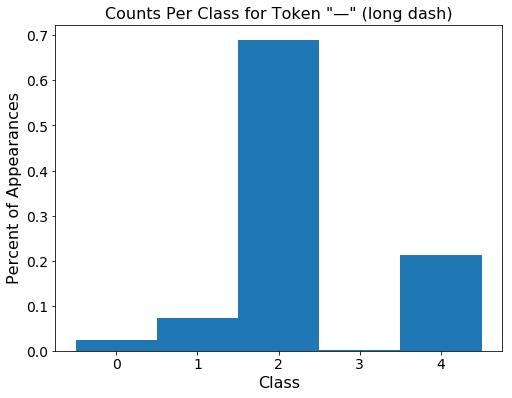

In [214]:
word = '—'
word_id = vocab[vocab['word'] == word].index[0]

word_counts = x_cls.loc[word_id]

fig = plt.figure(figsize=(8,6))
vals, centers = word_counts.values, list(word_counts.index)
vals = vals / float(vals.sum())
plt.bar(centers, vals, width=1)
plt.tick_params(labelsize=14)
plt.title('Counts Per Class for Token "%s" (long dash)' % word, fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Percent of Appearances', fontsize=16)
plt.show()
fig.savefig(osp.splitext(p)[0] + '__long_dash_counts.png')

In [177]:
df['text'].iloc[-1]

'<unk> supported the biggest amnesty bill in history for illegal <unk> advocated gun <unk> used <unk> stimulus to jump-start the <unk> favored personal diplomacy even with the <unk> sworn enemies and instituted tax increases in six of the eight years of his <unk> <unk> core beliefs that got <unk> elected and re-elected were <unk> lower <unk> smaller government and a <unk> more assertive <unk> <unk> <unk> was also a <unk> willing to <unk> able to improvise in pursuit of his goals <unk> most of <unk> eager to expand his <unk> <unk> <unk> current field of <unk> presidential candidates invokes <unk> as a patron <unk> but the characteristics that made him a successful politician seem lost on <unk> <unk> <unk> turned his party into a swamp of <unk> ideological extremism and pessimism about the <unk> <unk> in direct opposition to <unk> <unk> <unk> <unk> transformed primary season into a reality show of <unk> betrayals and open <unk> defying the so-called 11th <unk> that <unk> <unk> <unk> shal

In [178]:
np.hstack(df['z']).mean()

0.01186322526583449

In [179]:
with pd.option_context('display.max_rows', 6):
    display(df['z'].apply(np.mean))

0       0.022727
1       0.015152
2       0.000000
          ...   
4861    0.001236
4862    0.022250
4863    0.019778
Name: z, Length: 4864, dtype: float64

In [180]:
np.median(df['z'].apply(np.mean))

0.010498687664041995

In [181]:
is_all = df['z'].apply(np.all)
not_all = df.loc[~is_all]

In [182]:
np.median(not_all['z'].apply(np.mean))

0.010498687664041995

In [183]:
np.mean(np.hstack(not_all['z']))

0.01186322526583449

In [184]:
def pads_in_rationale(row, padding_id=400001):
    return np.mean(row['z'][row['x'] == padding_id])

In [185]:
padding_percent = not_all.apply(pads_in_rationale, axis='columns')
padding_percent = padding_percent[~padding_percent.isnull()]

C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


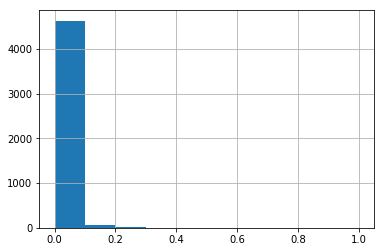

In [186]:
padding_percent = df.apply(pads_in_rationale, axis='columns')
padding_percent.hist()

In [187]:
(padding_percent != 1).mean()

0.9995888157894737

In [188]:
not_all_pad = df[padding_percent != 1]

In [189]:
np.mean(z_percent == 1)

0.0

In [190]:
np.mean(padding_percent == 1)

0.00041118421052631577

In [191]:
np.mean((z_percent != 1) & (padding_percent != 1))

0.9995888157894737

In [192]:
df2 = df[z_percent  <= 0.5]

In [193]:
r = df.iloc[0]
x = np.array(r['x'])
z = np.array(r['z'])
text = np.array(r['text'].split(' '))
print(400000, text[x == 400000])
print(400001, text[x == 400001])
print(0, text[x == 0])

400000 ['<unk>' '<unk>' '<unk>' '<unk>' '<unk>' '<unk>']
400001 ['<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'
 '<padding>' '<padding>' '<padding>' '<padding>' '<padding>'

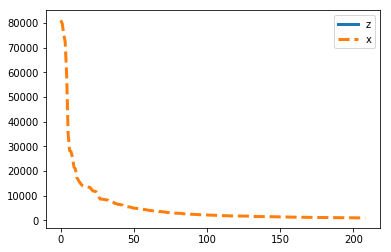

In [194]:
def get_z_ids_no_pad(row, padding_id=400001, unk_id=400000):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    not_pad = x != padding_id
    return x[z & not_pad].tolist()

def get_z_ids(row):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    return x[z].tolist()

def get_counts(a):
    a = pd.Series(a)
    counts = a.value_counts()
    counts = counts.iloc[3:]
    counts = counts[counts > 1000]
    return counts

zs = np.hstack(df.apply(get_z_ids, axis='columns'))
z_counts = get_counts(zs)

xs = np.hstack(df['x'])
x_counts = get_counts(xs)

plt.plot(z_counts.values, label='z', linewidth=3)
plt.plot(x_counts.values, '--', label='x', linewidth=3)
plt.legend()

ValueError: range parameter must be finite.

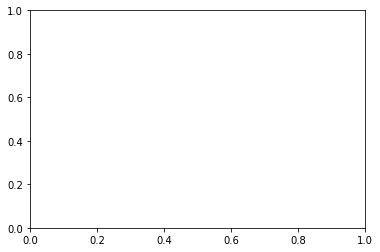

In [195]:
df_x = pd.DataFrame(x_counts).reset_index()
df_x.columns = ['word_id', 'count']

df_z = pd.DataFrame(z_counts).reset_index()
df_z.columns = ['word_id', 'count']

merged = pd.merge(df_x, df_z, on='word_id', how='outer', suffixes=('_x', '_z'))
merged.fillna(0, inplace=True)
# merged.plot(x='word_id', logy=True)
# merged.plot(x='word_id')

diff = merged['count_x'] - merged['count_z']
percent = merged['count_z'] / merged['count_x']
percent.hist()

In [ ]:
x_counts_by_host[0].plot(style='.', logy=True)

In [ ]:
a = x_counts_by_host[0]
a = a[a >= 100]
# a.hist(bins='auto')

In [ ]:
a.hist(bins=100)

In [ ]:
b = 10
mx = np.log(1000)/np.log(b)
num = np.ceil(mx) + 1
np.logspace(0, mx, num=num)

In [ ]:
def log_hist(a):
    log_base = 10
    mx = np.ceil(np.log(a.max())/np.log(log_base))
    ax = plt.axes()
    a.hist(bins=np.logspace(0, mx, num=mx+1))
    ax.set_xscale("log")
    ax.set_yscale("log")

log_hist(z_counts_by_host[0])

In [ ]:
i = -10
print(df.iloc[i]['text'])
print('\n\n\n')
print(df.iloc[i]['rationale'])
print('\n\n\n')
print(df.iloc[i]['z'])